# HAR LSTM training 

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from utilities import *
%matplotlib inline

## Prepare data

In [2]:
mydir = 'checkpoints' # output directory for model checkpointing

X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Standardize
X_train, X_test = standardize(X_train, X_test) 

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train,
                                                random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

### Hyperparameters

In [6]:
lstm_size = 27         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [7]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [8]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [9]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [10]:
if (os.path.exists(mydir) == False):
    os.mkdir(mydir)

In [11]:
%%time
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,mydir + "/har-lstm")

('Epoch: 0/1000', 'Iteration: 5', 'Train loss: 1.808878', 'Train acc: 0.150000')
('Epoch: 1/1000', 'Iteration: 10', 'Train loss: 1.824162', 'Train acc: 0.131667')
('Epoch: 1/1000', 'Iteration: 15', 'Train loss: 1.787557', 'Train acc: 0.206667')
('Epoch: 2/1000', 'Iteration: 20', 'Train loss: 1.792645', 'Train acc: 0.201667')
('Epoch: 2/1000', 'Iteration: 25', 'Train loss: 1.777686', 'Train acc: 0.208333')
('Epoch: 2/1000', 'Iteration: 25', 'Validation loss: 1.764534', 'Validation acc: 0.282778')
('Epoch: 3/1000', 'Iteration: 30', 'Train loss: 1.770892', 'Train acc: 0.238333')
('Epoch: 3/1000', 'Iteration: 35', 'Train loss: 1.772695', 'Train acc: 0.231667')
('Epoch: 4/1000', 'Iteration: 40', 'Train loss: 1.761210', 'Train acc: 0.248333')
('Epoch: 4/1000', 'Iteration: 45', 'Train loss: 1.754657', 'Train acc: 0.266667')
('Epoch: 5/1000', 'Iteration: 50', 'Train loss: 1.731292', 'Train acc: 0.293333')
('Epoch: 5/1000', 'Iteration: 50', 'Validation loss: 1.716621', 'Validation acc: 0.490556

('Epoch: 45/1000', 'Iteration: 410', 'Train loss: 1.014027', 'Train acc: 0.668333')
('Epoch: 46/1000', 'Iteration: 415', 'Train loss: 1.004716', 'Train acc: 0.670000')
('Epoch: 46/1000', 'Iteration: 420', 'Train loss: 0.984591', 'Train acc: 0.665000')
('Epoch: 47/1000', 'Iteration: 425', 'Train loss: 0.991605', 'Train acc: 0.653333')
('Epoch: 47/1000', 'Iteration: 425', 'Validation loss: 0.920715', 'Validation acc: 0.677222')
('Epoch: 47/1000', 'Iteration: 430', 'Train loss: 0.992172', 'Train acc: 0.668333')
('Epoch: 48/1000', 'Iteration: 435', 'Train loss: 1.021555', 'Train acc: 0.621667')
('Epoch: 48/1000', 'Iteration: 440', 'Train loss: 0.963051', 'Train acc: 0.691667')
('Epoch: 49/1000', 'Iteration: 445', 'Train loss: 1.020822', 'Train acc: 0.648333')
('Epoch: 49/1000', 'Iteration: 450', 'Train loss: 0.979815', 'Train acc: 0.660000')
('Epoch: 49/1000', 'Iteration: 450', 'Validation loss: 0.888094', 'Validation acc: 0.682222')
('Epoch: 50/1000', 'Iteration: 455', 'Train loss: 0.9288

('Epoch: 89/1000', 'Iteration: 810', 'Train loss: 0.669789', 'Train acc: 0.785000')
('Epoch: 90/1000', 'Iteration: 815', 'Train loss: 0.635887', 'Train acc: 0.808333')
('Epoch: 91/1000', 'Iteration: 820', 'Train loss: 0.644372', 'Train acc: 0.805000')
('Epoch: 91/1000', 'Iteration: 825', 'Train loss: 0.621212', 'Train acc: 0.826667')
('Epoch: 91/1000', 'Iteration: 825', 'Validation loss: 0.546390', 'Validation acc: 0.862778')
('Epoch: 92/1000', 'Iteration: 830', 'Train loss: 0.658225', 'Train acc: 0.813333')
('Epoch: 92/1000', 'Iteration: 835', 'Train loss: 0.646865', 'Train acc: 0.783333')
('Epoch: 93/1000', 'Iteration: 840', 'Train loss: 0.650412', 'Train acc: 0.796667')
('Epoch: 93/1000', 'Iteration: 845', 'Train loss: 0.581957', 'Train acc: 0.841667')
('Epoch: 94/1000', 'Iteration: 850', 'Train loss: 0.649130', 'Train acc: 0.800000')
('Epoch: 94/1000', 'Iteration: 850', 'Validation loss: 0.517645', 'Validation acc: 0.868333')
('Epoch: 94/1000', 'Iteration: 855', 'Train loss: 0.6109

('Epoch: 133/1000', 'Iteration: 1205', 'Train loss: 0.345422', 'Train acc: 0.931667')
('Epoch: 134/1000', 'Iteration: 1210', 'Train loss: 0.392090', 'Train acc: 0.906667')
('Epoch: 134/1000', 'Iteration: 1215', 'Train loss: 0.400109', 'Train acc: 0.905000')
('Epoch: 135/1000', 'Iteration: 1220', 'Train loss: 0.374504', 'Train acc: 0.910000')
('Epoch: 136/1000', 'Iteration: 1225', 'Train loss: 0.340279', 'Train acc: 0.915000')
('Epoch: 136/1000', 'Iteration: 1225', 'Validation loss: 0.271756', 'Validation acc: 0.927222')
('Epoch: 136/1000', 'Iteration: 1230', 'Train loss: 0.353682', 'Train acc: 0.910000')
('Epoch: 137/1000', 'Iteration: 1235', 'Train loss: 0.348811', 'Train acc: 0.925000')
('Epoch: 137/1000', 'Iteration: 1240', 'Train loss: 0.358671', 'Train acc: 0.925000')
('Epoch: 138/1000', 'Iteration: 1245', 'Train loss: 0.387329', 'Train acc: 0.891667')
('Epoch: 138/1000', 'Iteration: 1250', 'Train loss: 0.334882', 'Train acc: 0.930000')
('Epoch: 138/1000', 'Iteration: 1250', 'Vali

('Epoch: 177/1000', 'Iteration: 1600', 'Train loss: 0.272693', 'Train acc: 0.941667')
('Epoch: 177/1000', 'Iteration: 1600', 'Validation loss: 0.190164', 'Validation acc: 0.938889')
('Epoch: 178/1000', 'Iteration: 1605', 'Train loss: 0.300718', 'Train acc: 0.918333')
('Epoch: 178/1000', 'Iteration: 1610', 'Train loss: 0.234308', 'Train acc: 0.953333')
('Epoch: 179/1000', 'Iteration: 1615', 'Train loss: 0.328186', 'Train acc: 0.913333')
('Epoch: 179/1000', 'Iteration: 1620', 'Train loss: 0.293358', 'Train acc: 0.933333')
('Epoch: 180/1000', 'Iteration: 1625', 'Train loss: 0.260845', 'Train acc: 0.930000')
('Epoch: 180/1000', 'Iteration: 1625', 'Validation loss: 0.186979', 'Validation acc: 0.939444')
('Epoch: 181/1000', 'Iteration: 1630', 'Train loss: 0.238765', 'Train acc: 0.946667')
('Epoch: 181/1000', 'Iteration: 1635', 'Train loss: 0.238786', 'Train acc: 0.946667')
('Epoch: 182/1000', 'Iteration: 1640', 'Train loss: 0.249652', 'Train acc: 0.953333')
('Epoch: 182/1000', 'Iteration: 16

('Epoch: 221/1000', 'Iteration: 1990', 'Train loss: 0.209253', 'Train acc: 0.950000')
('Epoch: 221/1000', 'Iteration: 1995', 'Train loss: 0.189974', 'Train acc: 0.956667')
('Epoch: 222/1000', 'Iteration: 2000', 'Train loss: 0.207385', 'Train acc: 0.955000')
('Epoch: 222/1000', 'Iteration: 2000', 'Validation loss: 0.162633', 'Validation acc: 0.946667')
('Epoch: 222/1000', 'Iteration: 2005', 'Train loss: 0.217163', 'Train acc: 0.955000')
('Epoch: 223/1000', 'Iteration: 2010', 'Train loss: 0.229249', 'Train acc: 0.931667')
('Epoch: 223/1000', 'Iteration: 2015', 'Train loss: 0.190302', 'Train acc: 0.958333')
('Epoch: 224/1000', 'Iteration: 2020', 'Train loss: 0.245148', 'Train acc: 0.925000')
('Epoch: 224/1000', 'Iteration: 2025', 'Train loss: 0.231208', 'Train acc: 0.943333')
('Epoch: 224/1000', 'Iteration: 2025', 'Validation loss: 0.154833', 'Validation acc: 0.947778')
('Epoch: 225/1000', 'Iteration: 2030', 'Train loss: 0.223255', 'Train acc: 0.946667')
('Epoch: 226/1000', 'Iteration: 20

('Epoch: 264/1000', 'Iteration: 2380', 'Train loss: 0.206928', 'Train acc: 0.938333')
('Epoch: 264/1000', 'Iteration: 2385', 'Train loss: 0.192344', 'Train acc: 0.951667')
('Epoch: 265/1000', 'Iteration: 2390', 'Train loss: 0.177869', 'Train acc: 0.948333')
('Epoch: 266/1000', 'Iteration: 2395', 'Train loss: 0.182764', 'Train acc: 0.943333')
('Epoch: 266/1000', 'Iteration: 2400', 'Train loss: 0.180027', 'Train acc: 0.956667')
('Epoch: 266/1000', 'Iteration: 2400', 'Validation loss: 0.141048', 'Validation acc: 0.950556')
('Epoch: 267/1000', 'Iteration: 2405', 'Train loss: 0.185745', 'Train acc: 0.961667')
('Epoch: 267/1000', 'Iteration: 2410', 'Train loss: 0.198218', 'Train acc: 0.946667')
('Epoch: 268/1000', 'Iteration: 2415', 'Train loss: 0.205604', 'Train acc: 0.940000')
('Epoch: 268/1000', 'Iteration: 2420', 'Train loss: 0.153318', 'Train acc: 0.963333')
('Epoch: 269/1000', 'Iteration: 2425', 'Train loss: 0.192927', 'Train acc: 0.946667')
('Epoch: 269/1000', 'Iteration: 2425', 'Vali

('Epoch: 308/1000', 'Iteration: 2775', 'Train loss: 0.180812', 'Train acc: 0.943333')
('Epoch: 308/1000', 'Iteration: 2775', 'Validation loss: 0.130004', 'Validation acc: 0.952222')
('Epoch: 308/1000', 'Iteration: 2780', 'Train loss: 0.141794', 'Train acc: 0.963333')
('Epoch: 309/1000', 'Iteration: 2785', 'Train loss: 0.202739', 'Train acc: 0.931667')
('Epoch: 309/1000', 'Iteration: 2790', 'Train loss: 0.197893', 'Train acc: 0.940000')
('Epoch: 310/1000', 'Iteration: 2795', 'Train loss: 0.162387', 'Train acc: 0.948333')
('Epoch: 311/1000', 'Iteration: 2800', 'Train loss: 0.160628', 'Train acc: 0.956667')
('Epoch: 311/1000', 'Iteration: 2800', 'Validation loss: 0.134281', 'Validation acc: 0.952778')
('Epoch: 311/1000', 'Iteration: 2805', 'Train loss: 0.146478', 'Train acc: 0.958333')
('Epoch: 312/1000', 'Iteration: 2810', 'Train loss: 0.161042', 'Train acc: 0.961667')
('Epoch: 312/1000', 'Iteration: 2815', 'Train loss: 0.165875', 'Train acc: 0.953333')
('Epoch: 313/1000', 'Iteration: 28

('Epoch: 351/1000', 'Iteration: 3165', 'Train loss: 0.163829', 'Train acc: 0.953333')
('Epoch: 352/1000', 'Iteration: 3170', 'Train loss: 0.141132', 'Train acc: 0.960000')
('Epoch: 352/1000', 'Iteration: 3175', 'Train loss: 0.164758', 'Train acc: 0.946667')
('Epoch: 352/1000', 'Iteration: 3175', 'Validation loss: 0.127859', 'Validation acc: 0.951667')
('Epoch: 353/1000', 'Iteration: 3180', 'Train loss: 0.169325', 'Train acc: 0.946667')
('Epoch: 353/1000', 'Iteration: 3185', 'Train loss: 0.130658', 'Train acc: 0.958333')
('Epoch: 354/1000', 'Iteration: 3190', 'Train loss: 0.186154', 'Train acc: 0.940000')
('Epoch: 354/1000', 'Iteration: 3195', 'Train loss: 0.163404', 'Train acc: 0.951667')
('Epoch: 355/1000', 'Iteration: 3200', 'Train loss: 0.149575', 'Train acc: 0.946667')
('Epoch: 355/1000', 'Iteration: 3200', 'Validation loss: 0.127067', 'Validation acc: 0.951667')
('Epoch: 356/1000', 'Iteration: 3205', 'Train loss: 0.138649', 'Train acc: 0.961667')
('Epoch: 356/1000', 'Iteration: 32

('Epoch: 394/1000', 'Iteration: 3555', 'Train loss: 0.142924', 'Train acc: 0.956667')
('Epoch: 395/1000', 'Iteration: 3560', 'Train loss: 0.137598', 'Train acc: 0.956667')
('Epoch: 396/1000', 'Iteration: 3565', 'Train loss: 0.140537', 'Train acc: 0.960000')
('Epoch: 396/1000', 'Iteration: 3570', 'Train loss: 0.145410', 'Train acc: 0.956667')
('Epoch: 397/1000', 'Iteration: 3575', 'Train loss: 0.133362', 'Train acc: 0.963333')
('Epoch: 397/1000', 'Iteration: 3575', 'Validation loss: 0.113448', 'Validation acc: 0.956111')
('Epoch: 397/1000', 'Iteration: 3580', 'Train loss: 0.138289', 'Train acc: 0.950000')
('Epoch: 398/1000', 'Iteration: 3585', 'Train loss: 0.168243', 'Train acc: 0.945000')
('Epoch: 398/1000', 'Iteration: 3590', 'Train loss: 0.120901', 'Train acc: 0.961667')
('Epoch: 399/1000', 'Iteration: 3595', 'Train loss: 0.179015', 'Train acc: 0.935000')
('Epoch: 399/1000', 'Iteration: 3600', 'Train loss: 0.156546', 'Train acc: 0.951667')
('Epoch: 399/1000', 'Iteration: 3600', 'Vali

('Epoch: 438/1000', 'Iteration: 3950', 'Train loss: 0.109717', 'Train acc: 0.971667')
('Epoch: 438/1000', 'Iteration: 3950', 'Validation loss: 0.111072', 'Validation acc: 0.955555')
('Epoch: 439/1000', 'Iteration: 3955', 'Train loss: 0.168245', 'Train acc: 0.935000')
('Epoch: 439/1000', 'Iteration: 3960', 'Train loss: 0.135546', 'Train acc: 0.961667')
('Epoch: 440/1000', 'Iteration: 3965', 'Train loss: 0.141586', 'Train acc: 0.948333')
('Epoch: 441/1000', 'Iteration: 3970', 'Train loss: 0.122147', 'Train acc: 0.956667')
('Epoch: 441/1000', 'Iteration: 3975', 'Train loss: 0.127707', 'Train acc: 0.960000')
('Epoch: 441/1000', 'Iteration: 3975', 'Validation loss: 0.118342', 'Validation acc: 0.952778')
('Epoch: 442/1000', 'Iteration: 3980', 'Train loss: 0.130269', 'Train acc: 0.958333')
('Epoch: 442/1000', 'Iteration: 3985', 'Train loss: 0.139775', 'Train acc: 0.948333')
('Epoch: 443/1000', 'Iteration: 3990', 'Train loss: 0.166192', 'Train acc: 0.948333')
('Epoch: 443/1000', 'Iteration: 39

('Epoch: 482/1000', 'Iteration: 4340', 'Train loss: 0.124648', 'Train acc: 0.956667')
('Epoch: 482/1000', 'Iteration: 4345', 'Train loss: 0.141609', 'Train acc: 0.950000')
('Epoch: 483/1000', 'Iteration: 4350', 'Train loss: 0.133368', 'Train acc: 0.956667')
('Epoch: 483/1000', 'Iteration: 4350', 'Validation loss: 0.115044', 'Validation acc: 0.952222')
('Epoch: 483/1000', 'Iteration: 4355', 'Train loss: 0.105439', 'Train acc: 0.973333')
('Epoch: 484/1000', 'Iteration: 4360', 'Train loss: 0.148504', 'Train acc: 0.943333')
('Epoch: 484/1000', 'Iteration: 4365', 'Train loss: 0.137477', 'Train acc: 0.951667')
('Epoch: 485/1000', 'Iteration: 4370', 'Train loss: 0.133983', 'Train acc: 0.948333')
('Epoch: 486/1000', 'Iteration: 4375', 'Train loss: 0.109710', 'Train acc: 0.963333')
('Epoch: 486/1000', 'Iteration: 4375', 'Validation loss: 0.115055', 'Validation acc: 0.952778')
('Epoch: 486/1000', 'Iteration: 4380', 'Train loss: 0.128397', 'Train acc: 0.950000')
('Epoch: 487/1000', 'Iteration: 43

('Epoch: 525/1000', 'Iteration: 4730', 'Train loss: 0.136112', 'Train acc: 0.943333')
('Epoch: 526/1000', 'Iteration: 4735', 'Train loss: 0.117530', 'Train acc: 0.956667')
('Epoch: 526/1000', 'Iteration: 4740', 'Train loss: 0.113458', 'Train acc: 0.963333')
('Epoch: 527/1000', 'Iteration: 4745', 'Train loss: 0.118316', 'Train acc: 0.951667')
('Epoch: 527/1000', 'Iteration: 4750', 'Train loss: 0.130121', 'Train acc: 0.950000')
('Epoch: 527/1000', 'Iteration: 4750', 'Validation loss: 0.114827', 'Validation acc: 0.953889')
('Epoch: 528/1000', 'Iteration: 4755', 'Train loss: 0.153107', 'Train acc: 0.936667')
('Epoch: 528/1000', 'Iteration: 4760', 'Train loss: 0.102749', 'Train acc: 0.961667')
('Epoch: 529/1000', 'Iteration: 4765', 'Train loss: 0.139170', 'Train acc: 0.946667')
('Epoch: 529/1000', 'Iteration: 4770', 'Train loss: 0.143448', 'Train acc: 0.955000')
('Epoch: 530/1000', 'Iteration: 4775', 'Train loss: 0.131579', 'Train acc: 0.955000')
('Epoch: 530/1000', 'Iteration: 4775', 'Vali

('Epoch: 569/1000', 'Iteration: 5125', 'Train loss: 0.137876', 'Train acc: 0.940000')
('Epoch: 569/1000', 'Iteration: 5125', 'Validation loss: 0.116120', 'Validation acc: 0.952778')
('Epoch: 569/1000', 'Iteration: 5130', 'Train loss: 0.143860', 'Train acc: 0.951667')
('Epoch: 570/1000', 'Iteration: 5135', 'Train loss: 0.121895', 'Train acc: 0.955000')
('Epoch: 571/1000', 'Iteration: 5140', 'Train loss: 0.098486', 'Train acc: 0.961667')
('Epoch: 571/1000', 'Iteration: 5145', 'Train loss: 0.122995', 'Train acc: 0.958333')
('Epoch: 572/1000', 'Iteration: 5150', 'Train loss: 0.109388', 'Train acc: 0.965000')
('Epoch: 572/1000', 'Iteration: 5150', 'Validation loss: 0.115623', 'Validation acc: 0.952222')
('Epoch: 572/1000', 'Iteration: 5155', 'Train loss: 0.117423', 'Train acc: 0.955000')
('Epoch: 573/1000', 'Iteration: 5160', 'Train loss: 0.142887', 'Train acc: 0.941667')
('Epoch: 573/1000', 'Iteration: 5165', 'Train loss: 0.098795', 'Train acc: 0.966667')
('Epoch: 574/1000', 'Iteration: 51

('Epoch: 612/1000', 'Iteration: 5515', 'Train loss: 0.113219', 'Train acc: 0.968333')
('Epoch: 613/1000', 'Iteration: 5520', 'Train loss: 0.137785', 'Train acc: 0.951667')
('Epoch: 613/1000', 'Iteration: 5525', 'Train loss: 0.104098', 'Train acc: 0.965000')
('Epoch: 613/1000', 'Iteration: 5525', 'Validation loss: 0.113328', 'Validation acc: 0.951111')
('Epoch: 614/1000', 'Iteration: 5530', 'Train loss: 0.151018', 'Train acc: 0.950000')
('Epoch: 614/1000', 'Iteration: 5535', 'Train loss: 0.125299', 'Train acc: 0.963333')
('Epoch: 615/1000', 'Iteration: 5540', 'Train loss: 0.128997', 'Train acc: 0.951667')
('Epoch: 616/1000', 'Iteration: 5545', 'Train loss: 0.101901', 'Train acc: 0.958333')
('Epoch: 616/1000', 'Iteration: 5550', 'Train loss: 0.111147', 'Train acc: 0.965000')
('Epoch: 616/1000', 'Iteration: 5550', 'Validation loss: 0.111811', 'Validation acc: 0.952222')
('Epoch: 617/1000', 'Iteration: 5555', 'Train loss: 0.113351', 'Train acc: 0.966667')
('Epoch: 617/1000', 'Iteration: 55

('Epoch: 656/1000', 'Iteration: 5905', 'Train loss: 0.099181', 'Train acc: 0.958333')
('Epoch: 656/1000', 'Iteration: 5910', 'Train loss: 0.118520', 'Train acc: 0.951667')
('Epoch: 657/1000', 'Iteration: 5915', 'Train loss: 0.107660', 'Train acc: 0.960000')
('Epoch: 657/1000', 'Iteration: 5920', 'Train loss: 0.123318', 'Train acc: 0.951667')
('Epoch: 658/1000', 'Iteration: 5925', 'Train loss: 0.135420', 'Train acc: 0.938333')
('Epoch: 658/1000', 'Iteration: 5925', 'Validation loss: 0.115054', 'Validation acc: 0.951667')
('Epoch: 658/1000', 'Iteration: 5930', 'Train loss: 0.091993', 'Train acc: 0.970000')
('Epoch: 659/1000', 'Iteration: 5935', 'Train loss: 0.136374', 'Train acc: 0.935000')
('Epoch: 659/1000', 'Iteration: 5940', 'Train loss: 0.106903', 'Train acc: 0.956667')
('Epoch: 660/1000', 'Iteration: 5945', 'Train loss: 0.125888', 'Train acc: 0.946667')
('Epoch: 661/1000', 'Iteration: 5950', 'Train loss: 0.113932', 'Train acc: 0.953333')
('Epoch: 661/1000', 'Iteration: 5950', 'Vali

('Epoch: 699/1000', 'Iteration: 6300', 'Train loss: 0.125932', 'Train acc: 0.960000')
('Epoch: 699/1000', 'Iteration: 6300', 'Validation loss: 0.105378', 'Validation acc: 0.954444')
('Epoch: 700/1000', 'Iteration: 6305', 'Train loss: 0.118869', 'Train acc: 0.956667')
('Epoch: 701/1000', 'Iteration: 6310', 'Train loss: 0.098178', 'Train acc: 0.965000')
('Epoch: 701/1000', 'Iteration: 6315', 'Train loss: 0.090888', 'Train acc: 0.968333')
('Epoch: 702/1000', 'Iteration: 6320', 'Train loss: 0.092837', 'Train acc: 0.965000')
('Epoch: 702/1000', 'Iteration: 6325', 'Train loss: 0.111240', 'Train acc: 0.961667')
('Epoch: 702/1000', 'Iteration: 6325', 'Validation loss: 0.109383', 'Validation acc: 0.955000')
('Epoch: 703/1000', 'Iteration: 6330', 'Train loss: 0.135557', 'Train acc: 0.943333')
('Epoch: 703/1000', 'Iteration: 6335', 'Train loss: 0.095027', 'Train acc: 0.970000')
('Epoch: 704/1000', 'Iteration: 6340', 'Train loss: 0.143490', 'Train acc: 0.938333')
('Epoch: 704/1000', 'Iteration: 63

('Epoch: 743/1000', 'Iteration: 6690', 'Train loss: 0.118761', 'Train acc: 0.951667')
('Epoch: 743/1000', 'Iteration: 6695', 'Train loss: 0.082298', 'Train acc: 0.968333')
('Epoch: 744/1000', 'Iteration: 6700', 'Train loss: 0.140003', 'Train acc: 0.930000')
('Epoch: 744/1000', 'Iteration: 6700', 'Validation loss: 0.113225', 'Validation acc: 0.952778')
('Epoch: 744/1000', 'Iteration: 6705', 'Train loss: 0.111399', 'Train acc: 0.965000')
('Epoch: 745/1000', 'Iteration: 6710', 'Train loss: 0.123318', 'Train acc: 0.951667')
('Epoch: 746/1000', 'Iteration: 6715', 'Train loss: 0.091542', 'Train acc: 0.973333')
('Epoch: 746/1000', 'Iteration: 6720', 'Train loss: 0.108329', 'Train acc: 0.958333')
('Epoch: 747/1000', 'Iteration: 6725', 'Train loss: 0.101984', 'Train acc: 0.966667')
('Epoch: 747/1000', 'Iteration: 6725', 'Validation loss: 0.112282', 'Validation acc: 0.953333')
('Epoch: 747/1000', 'Iteration: 6730', 'Train loss: 0.108814', 'Train acc: 0.963333')
('Epoch: 748/1000', 'Iteration: 67

('Epoch: 786/1000', 'Iteration: 7080', 'Train loss: 0.098802', 'Train acc: 0.960000')
('Epoch: 787/1000', 'Iteration: 7085', 'Train loss: 0.103550', 'Train acc: 0.956667')
('Epoch: 787/1000', 'Iteration: 7090', 'Train loss: 0.115612', 'Train acc: 0.956667')
('Epoch: 788/1000', 'Iteration: 7095', 'Train loss: 0.129509', 'Train acc: 0.946667')
('Epoch: 788/1000', 'Iteration: 7100', 'Train loss: 0.089209', 'Train acc: 0.966667')
('Epoch: 788/1000', 'Iteration: 7100', 'Validation loss: 0.098001', 'Validation acc: 0.953889')
('Epoch: 789/1000', 'Iteration: 7105', 'Train loss: 0.133574', 'Train acc: 0.931667')
('Epoch: 789/1000', 'Iteration: 7110', 'Train loss: 0.103797', 'Train acc: 0.970000')
('Epoch: 790/1000', 'Iteration: 7115', 'Train loss: 0.112618', 'Train acc: 0.950000')
('Epoch: 791/1000', 'Iteration: 7120', 'Train loss: 0.102622', 'Train acc: 0.961667')
('Epoch: 791/1000', 'Iteration: 7125', 'Train loss: 0.101488', 'Train acc: 0.965000')
('Epoch: 791/1000', 'Iteration: 7125', 'Vali

('Epoch: 830/1000', 'Iteration: 7475', 'Train loss: 0.111192', 'Train acc: 0.955000')
('Epoch: 830/1000', 'Iteration: 7475', 'Validation loss: 0.121306', 'Validation acc: 0.952778')
('Epoch: 831/1000', 'Iteration: 7480', 'Train loss: 0.098875', 'Train acc: 0.961667')
('Epoch: 831/1000', 'Iteration: 7485', 'Train loss: 0.109357', 'Train acc: 0.958333')
('Epoch: 832/1000', 'Iteration: 7490', 'Train loss: 0.097749', 'Train acc: 0.963333')
('Epoch: 832/1000', 'Iteration: 7495', 'Train loss: 0.109063', 'Train acc: 0.953333')
('Epoch: 833/1000', 'Iteration: 7500', 'Train loss: 0.126443', 'Train acc: 0.941667')
('Epoch: 833/1000', 'Iteration: 7500', 'Validation loss: 0.105541', 'Validation acc: 0.955000')
('Epoch: 833/1000', 'Iteration: 7505', 'Train loss: 0.073019', 'Train acc: 0.971667')
('Epoch: 834/1000', 'Iteration: 7510', 'Train loss: 0.122945', 'Train acc: 0.948333')
('Epoch: 834/1000', 'Iteration: 7515', 'Train loss: 0.099917', 'Train acc: 0.956667')
('Epoch: 835/1000', 'Iteration: 75

('Epoch: 873/1000', 'Iteration: 7865', 'Train loss: 0.070513', 'Train acc: 0.976667')
('Epoch: 874/1000', 'Iteration: 7870', 'Train loss: 0.126649', 'Train acc: 0.943333')
('Epoch: 874/1000', 'Iteration: 7875', 'Train loss: 0.110313', 'Train acc: 0.958333')
('Epoch: 874/1000', 'Iteration: 7875', 'Validation loss: 0.108925', 'Validation acc: 0.953889')
('Epoch: 875/1000', 'Iteration: 7880', 'Train loss: 0.112558', 'Train acc: 0.955000')
('Epoch: 876/1000', 'Iteration: 7885', 'Train loss: 0.094826', 'Train acc: 0.960000')
('Epoch: 876/1000', 'Iteration: 7890', 'Train loss: 0.098626', 'Train acc: 0.953333')
('Epoch: 877/1000', 'Iteration: 7895', 'Train loss: 0.090789', 'Train acc: 0.970000')
('Epoch: 877/1000', 'Iteration: 7900', 'Train loss: 0.104185', 'Train acc: 0.956667')
('Epoch: 877/1000', 'Iteration: 7900', 'Validation loss: 0.109906', 'Validation acc: 0.952778')
('Epoch: 878/1000', 'Iteration: 7905', 'Train loss: 0.115919', 'Train acc: 0.955000')
('Epoch: 878/1000', 'Iteration: 79

('Epoch: 917/1000', 'Iteration: 8255', 'Train loss: 0.105106', 'Train acc: 0.966667')
('Epoch: 917/1000', 'Iteration: 8260', 'Train loss: 0.104949', 'Train acc: 0.966667')
('Epoch: 918/1000', 'Iteration: 8265', 'Train loss: 0.110144', 'Train acc: 0.956667')
('Epoch: 918/1000', 'Iteration: 8270', 'Train loss: 0.078864', 'Train acc: 0.968333')
('Epoch: 919/1000', 'Iteration: 8275', 'Train loss: 0.119466', 'Train acc: 0.940000')
('Epoch: 919/1000', 'Iteration: 8275', 'Validation loss: 0.115432', 'Validation acc: 0.952778')
('Epoch: 919/1000', 'Iteration: 8280', 'Train loss: 0.103405', 'Train acc: 0.953333')
('Epoch: 920/1000', 'Iteration: 8285', 'Train loss: 0.102117', 'Train acc: 0.955000')
('Epoch: 921/1000', 'Iteration: 8290', 'Train loss: 0.090920', 'Train acc: 0.966667')
('Epoch: 921/1000', 'Iteration: 8295', 'Train loss: 0.095798', 'Train acc: 0.960000')
('Epoch: 922/1000', 'Iteration: 8300', 'Train loss: 0.097051', 'Train acc: 0.965000')
('Epoch: 922/1000', 'Iteration: 8300', 'Vali

('Epoch: 961/1000', 'Iteration: 8650', 'Train loss: 0.094176', 'Train acc: 0.955000')
('Epoch: 961/1000', 'Iteration: 8650', 'Validation loss: 0.118320', 'Validation acc: 0.953889')
('Epoch: 961/1000', 'Iteration: 8655', 'Train loss: 0.091971', 'Train acc: 0.961667')
('Epoch: 962/1000', 'Iteration: 8660', 'Train loss: 0.092569', 'Train acc: 0.966667')
('Epoch: 962/1000', 'Iteration: 8665', 'Train loss: 0.108027', 'Train acc: 0.955000')
('Epoch: 963/1000', 'Iteration: 8670', 'Train loss: 0.112653', 'Train acc: 0.956667')
('Epoch: 963/1000', 'Iteration: 8675', 'Train loss: 0.071305', 'Train acc: 0.971667')
('Epoch: 963/1000', 'Iteration: 8675', 'Validation loss: 0.114288', 'Validation acc: 0.953333')
('Epoch: 964/1000', 'Iteration: 8680', 'Train loss: 0.133405', 'Train acc: 0.938333')
('Epoch: 964/1000', 'Iteration: 8685', 'Train loss: 0.101621', 'Train acc: 0.960000')
('Epoch: 965/1000', 'Iteration: 8690', 'Train loss: 0.104982', 'Train acc: 0.950000')
('Epoch: 966/1000', 'Iteration: 86

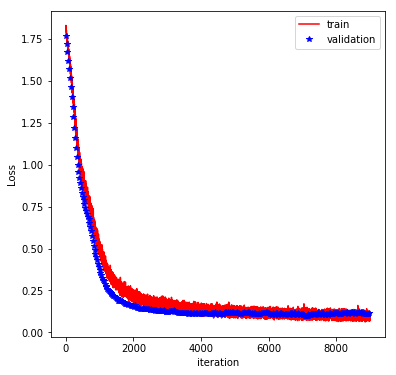

In [12]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

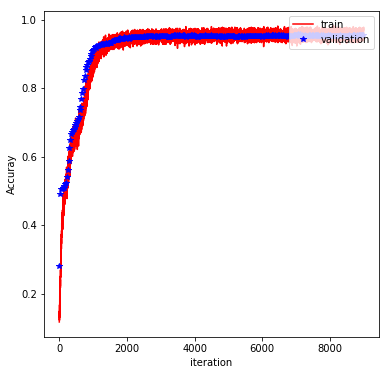

In [13]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [14]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint(mydir))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm
Test accuracy: 0.909583
